In [3]:
#setup
!pip install torch torchvision torchaudio
!pip install matplotlib numpy pillow tqdm scikit-image

In [2]:
#libraries import
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#define paths
base_dir = '/content/drive/MyDrive/project_datasets/CT to MRI brain images/images'

trainA_path = os.path.join(base_dir, 'trainA')  # Train CT
trainB_path = os.path.join(base_dir, 'trainB')  # Train MRI
testA_path  = os.path.join(base_dir, 'testA')   # CT test
testB_path  = os.path.join(base_dir, 'testB')   # MRI test

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, folder_path, image_size=64, transform=None):
        self.folder_path = folder_path
        self.image_size = image_size
        self.transform = transform
        self.images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        else:
            default_transform = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            img = default_transform(img)
        return img


In [7]:
#dataloader
image_size = 256
batch_size = 4

trainA_dataset = CustomDataset(trainA_path, image_size)
trainB_dataset = CustomDataset(trainB_path, image_size)

trainA_loader = DataLoader(trainA_dataset, batch_size=batch_size, shuffle=True)
trainB_loader = DataLoader(trainB_dataset, batch_size=batch_size, shuffle=True)

In [8]:
#Visualization of sample images

#function to show images
def show_images(ct_batch, mri_batch, n=4):
    plt.figure(figsize=(10,4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow((ct_batch[i].permute(1,2,0)*0.5 + 0.5).numpy())
        plt.title("CT Image")
        plt.axis("off")

        plt.subplot(2, n, n+i+1)
        plt.imshow((mri_batch[i].permute(1,2,0)*0.5 + 0.5).numpy())
        plt.title("MRI Image")
        plt.axis("off")
    plt.show()


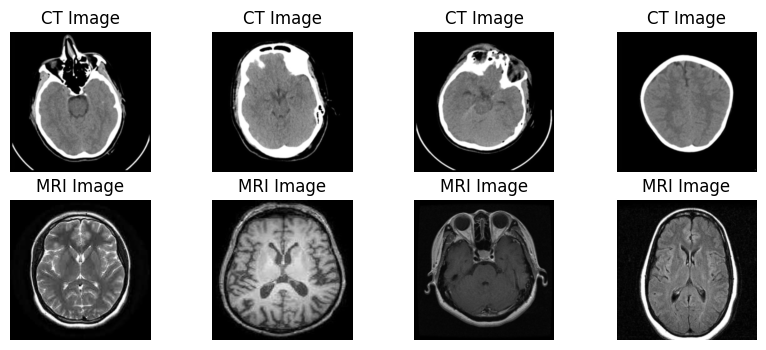

In [9]:
ct_batch = next(iter(trainA_loader))
mri_batch = next(iter(trainB_loader))
show_images(ct_batch, mri_batch)

In [10]:
#save preproccessed data
torch.save(ct_batch, '/content/drive/MyDrive/project_datasets/CT to MRI brain images/preprocessed_ct.pt')
torch.save(mri_batch, '/content/drive/MyDrive/project_datasets/CT to MRI brain images/preprocessed_mri.pt')


In [11]:
trainA_loader

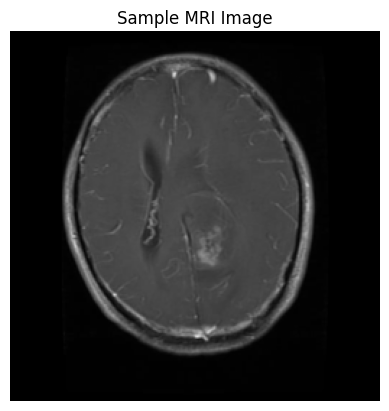

In [12]:
mri_batch = next(iter(trainB_loader))
plt.imshow((mri_batch[0].permute(1,2,0)*0.5 + 0.5))
plt.title("Sample MRI Image")
plt.axis("off")
plt.show()


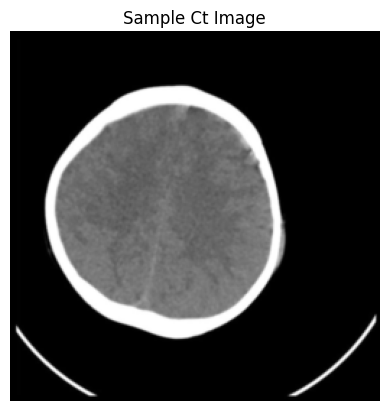

In [13]:
ct_batch = next(iter(trainA_loader))
plt.imshow((ct_batch[0].permute(1,2,0)*0.5 + 0.5))
plt.title("Sample Ct Image")
plt.axis("off")
plt.show()


In [14]:
#noise schedule and forward diffusion process
T = 300  # number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def q_sample(x_start, t, noise=None):
    """Add noise to x_start at step t."""
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = alphas_cumprod[t] ** 0.5
    sqrt_one_minus_alphas_cumprod_t = (1 - alphas_cumprod[t]) ** 0.5
    return sqrt_alphas_cumprod_t[:, None, None, None] * x_start + \
           sqrt_one_minus_alphas_cumprod_t[:, None, None, None] * noise


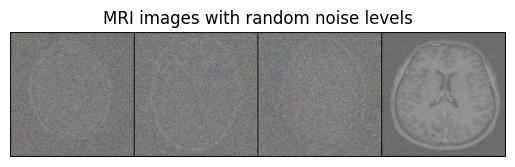

In [15]:
#Visualize
x = mri_batch[:8]
t = torch.randint(0, T, (x.shape[0],))
noisy = q_sample(x, t)
grid = make_grid(noisy, nrow=4, normalize=True)
plt.imshow(grid.permute(1,2,0).detach().numpy())
plt.title("MRI images with random noise levels")
plt.axis("off")
plt.show()


In [16]:
#define U net model
class DoubleConv(nn.Module):
    """(conv => ReLU => conv => ReLU)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscale with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    """Upscale + concatenate + DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # adjust size mismatch if any
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class ImprovedUNet(nn.Module):
    """Deeper UNet for diffusion"""
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=256):
        super().__init__()
        # time embedding layer (optional for diffusion step conditioning)
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        # Linear layer to project time embedding to match x4 channels
        self.time_proj = nn.Linear(time_emb_dim, 512)

        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.outc = OutConv(64, out_channels)


    def forward(self, x, t):
        # t: diffusion timestep
        t = t.float().unsqueeze(-1) / 1000  # scale timestep
        time_emb = self.time_mlp(t)  # shape: [batch, 256]
        time_emb = self.time_proj(time_emb) # project time embedding to 512 channels
        time_emb = time_emb[:, :, None, None]  # reshape for broadcasting

        # encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        # decoder with time conditioning
        x = x4 + time_emb
        x = self.up1(x, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        output = self.outc(x)
        return output

In [ ]:
import torch
import torch.nn.functional as F

# device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# model and optimizer
model = ImprovedUNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 100  # demo training

# make sure alphas_cumprod is on correct device
alphas_cumprod = alphas_cumprod.to(device)

for epoch in range(epochs):
    for i, real in enumerate(trainB_loader):
        real = real.to(device)

        # sample random timestep
        t = torch.randint(0, T, (real.shape[0],), device=device)

        # generate random Gaussian noise
        noise = torch.randn_like(real)

        # forward diffusion: add noise to image
        x_noisy = q_sample(real, t, noise)

        # model predicts the noise
        noise_pred = model(x_noisy, t)

        # compute loss (how close is predicted noise to true noise)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log progress
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Step [{i}] Loss: {loss.item():.4f}")

Using device: cuda


/tmp/ipython-input-1911847624.py:34: UserWarning: Using a target size (torch.Size([4, 3, 256, 256])) that is different to the input size (torch.Size([4, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(noise_pred, noise)


Epoch [1/100] Step [0] Loss: 1.1399
Epoch [1/100] Step [100] Loss: 0.7051
Epoch [1/100] Step [200] Loss: 0.7020
Epoch [1/100] Step [300] Loss: 0.6914
Epoch [1/100] Step [400] Loss: 0.6957
Epoch [2/100] Step [0] Loss: 0.6856
Epoch [2/100] Step [100] Loss: 0.7605
Epoch [2/100] Step [200] Loss: 0.6863
Epoch [2/100] Step [300] Loss: 0.7010
Epoch [2/100] Step [400] Loss: 0.7301
Epoch [3/100] Step [0] Loss: 0.7091
Epoch [3/100] Step [100] Loss: 0.6889
Epoch [3/100] Step [200] Loss: 0.6860
Epoch [3/100] Step [300] Loss: 0.6821
Epoch [3/100] Step [400] Loss: 0.7070
Epoch [4/100] Step [0] Loss: 0.6835
Epoch [4/100] Step [100] Loss: 0.6825
Epoch [4/100] Step [200] Loss: 0.7005
Epoch [4/100] Step [300] Loss: 0.7388
Epoch [4/100] Step [400] Loss: 0.6909
Epoch [5/100] Step [0] Loss: 0.6824
Epoch [5/100] Step [100] Loss: 0.6949
Epoch [5/100] Step [200] Loss: 0.6954
Epoch [5/100] Step [300] Loss: 0.6876
Epoch [5/100] Step [400] Loss: 0.6880
Epoch [6/100] Step [0] Loss: 0.6960
Epoch [6/100] Step [100]

In [ ]:
#sampling reverse process
@torch.no_grad()
def p_sample(model, x, t):
    beta_t = betas[t]
    sqrt_one_minus_alpha = (1 - alphas[t]) ** 0.5
    alpha_t = alphas[t]
    eps_theta = model(x, torch.tensor([t], device=device))
    mean = (1 / alpha_t ** 0.5) * (x - beta_t / sqrt_one_minus_alpha * eps_theta)
    if t > 0:
        z = torch.randn_like(x)
        sigma_t = beta_t ** 0.5
        sample = mean + sigma_t * z
    else:
        sample = mean
    return sample

@torch.no_grad()
def sample_images(model, n=4):
    x = torch.randn(n, 3, 64, 64, device=device)
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    return x

generated = sample_images(model, n=4)
grid = make_grid(generated, nrow=2, normalize=True)
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.title("Generated MRI-like images (Diffusion)")
plt.axis("off")
plt.show()


In [ ]:
torch.save(model.state_dict(), "diffusion_mri_model.pth")


In [ ]:
# Save trained model (for later re-use or Streamlit app)
torch.save(model.state_dict(), '/content/drive/MyDrive/project_datasets/CT to MRI brain images/diffusion_model.pth')
print("Model saved successfully.")


In [ ]:
class CTTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = sorted(glob.glob(root_dir + "/*.png"))  # or .jpg if needed
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


In [ ]:
#load test CT images
# from torchvision import datasets # No longer needed
# transform = transforms.Compose([ # Defined in CustomDataset
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

testA_path = "/content/drive/MyDrive/project_datasets/CT to MRI brain images/images/testA"
#testA_dataset = datasets.ImageFolder("/content/drive/MyDrive/project_datasets/CT to MRI brain images/images\testA", transform=transform) # Use CustomDataset instead
testA_dataset = CustomDataset(testA_path, image_size=128) # Reusing CustomDataset

# Check if the dataset is empty
if len(testA_dataset) == 0:
    print(f"Error: No image files found in {testA_path}. Please check the path and ensure it contains images.")
else:
    testA_loader = DataLoader(testA_dataset, batch_size=4, shuffle=True)

    ct_batch = next(iter(testA_loader)) # Removed unpacking as CustomDataset returns single item
    ct_batch = ct_batch.to(device)
    print("CT batch shape:", ct_batch.shape)

In [ ]:
#reverse diffusion process
# assume alphas_cumprod and betas are the same as defined during training
T = 1000
beta_start, beta_end = 0.0001, 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

@torch.no_grad()
def p_sample(x, t):
    """Reverse one diffusion step"""
    betas_t = betas[t]
    sqrt_one_minus_alpha = torch.sqrt(1 - alphas_cumprod[t])
    sqrt_recip_alpha = torch.sqrt(1 / alphas[t])

    # Predict noise
    eps_theta = model(x, torch.tensor([t], device=device))

    model_mean = sqrt_recip_alpha * (x - betas_t / sqrt_one_minus_alpha * eps_theta)
    if t > 0:
        noise = torch.randn_like(x)
    else:
        noise = 0
    sigma_t = torch.sqrt(betas_t)
    return model_mean + sigma_t * noise


@torch.no_grad()
def sample_mri_from_ct(ct_image):
    """Generate MRI-like image from CT using reverse diffusion"""
    x = ct_image
    for t in reversed(range(T)):
        if t % 200 == 0:
            print(f"Step {t}/{T}")
        x = p_sample(x, t)
    return x


In [ ]:
#generate mri like image
generated_images = []
for i in range(min(2, len(ct_batch))):
    gen_img = sample_mri_from_ct(ct_batch[i].unsqueeze(0))
    generated_images.append(gen_img)

generated_images = torch.cat(generated_images)
print("Generated images shape:", generated_images.shape)


In [ ]:
#visualize results
def show_ct_to_mri(ct_imgs, gen_imgs, n=2):
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        # Scale CT image data to [0, 1] for display
        ct_img_display = (ct_imgs[i].cpu().permute(1,2,0) * 0.5 + 0.5).clamp(0, 1)
        plt.imshow(ct_img_display)
        plt.title("CT Input")
        plt.axis("off")

        plt.subplot(2, n, n + i + 1)
        # Scale generated image data to [0, 1] for display
        gen_img_display = (gen_imgs[i].cpu().permute(1,2,0) * 0.5 + 0.5).clamp(0, 1)
        plt.imshow(gen_img_display)
        plt.title("Generated MRI")
        plt.axis("off")
    plt.show()

show_ct_to_mri(ct_batch, generated_images)